# Coursework1

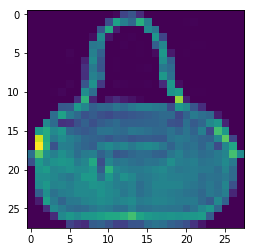

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn import preprocessing

# Loading the dataset
os.getcwd()
train_dataset = pd.read_csv("fashion-mnist_train.csv")

train_x = []
for i in range(0, 600):
    first_row_train = np.array(train_dataset.iloc[i][1:])
    picture_train = np.reshape(first_row_train, (28, 28))
    train_x.append(picture_train)
    
trainSetX = np.array(train_x) # your train set features -- print(trainSetX.shape) -- (6000, 28, 28)         
trainSetY = np.array(train_dataset.label[0:600][:]) 
trainSetY = trainSetY.reshape((1, trainSetY.shape[0])).T 
binarizer = preprocessing.LabelBinarizer()
trainSetY = binarizer.fit_transform(trainSetY) # your train set labels -- print(trainSetY.shape) -- (6000，10)

test_dataset = pd.read_csv("fashion-mnist_test.csv")
test_x = []
for i in range(0, 10000):
    first_row_test = np.array(test_dataset.iloc[i][1:])
    picture_test = np.reshape(first_row_test, (28, 28))
    test_x.append(picture_test)

testSetX = np.array(test_x) # your test set features -- print(testSetX.shape) -- (1000, 28, 28)
testSetY = np.array(test_dataset.label[0:10000][:]) 
testSetY = testSetY.reshape((1, testSetY.shape[0])).T
binarizer = preprocessing.LabelBinarizer()
testSetY = binarizer.fit_transform(testSetY) # your test set labels -- print(testSetY.shape) -- (1000, 10)

# Example of a picture
index = 20
plt.imshow(trainSetX[index])
plt.show()


In [84]:
# Flatten the pictures
trainSetXF= trainSetX.reshape(trainSetX.shape[0], -1).T # print(trainSetXF.shape) -- (784, 6000)
testSetXF = testSetX.reshape(testSetX.shape[0], -1).T # print(testSetXF.shape) -- (784, 1000)

# Standardise the dataset
trainSetXS = trainSetXF/255
testSetXS = testSetXF/255

#print(trainSetXS.shape)
#print(testSetXS.shape)
#print(testSetY.shape)
#print(trainSetY.shape)

In [85]:
# Topology: define the network of structure

# m -- the number of train examples
# m_test -- the number of test examples
# n_i -- number of input units - 28 by 28 pixel images
# n_h_l -- number of hidden layers 
# n_h -- number of hidden neurons - 2/3 * n_i + n_o
# n_o -- number of outputs - 10 target classes 

n_i = trainSetXS.shape[0]
n_h_l = 1
n_o = 10

# Activation Function: Tanh - hidden layers
# z = W^T*X+b
# t -- tanh activation function
def tanh(z):
    t = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    return t

# Activation Function: Softmax - output layer
# z = W^T*X+b
# s -- softmax activation function
def softmax(z):
    s = np.exp(z)/np.sum(np.exp(z),axis=0)
    return s


In [86]:
# Initialize the model's parameters
def initialize_parameters(n_i, n_h, n_o):

    # w1 -- weight matrix of shape (n_i, n_h)
    # w2 -- weight matrix of shape (n_h, n_o)
    # b1 -- bias vector of shape (n_h, 1)
    # b2 -- bias vector of shape (n_o, 1)  
    w1 = np.random.random(size = (n_i, n_h)) - 0.5
    w2 = np.random.random(size = (n_h, n_o)) - 0.5
    b1 = np.zeros((n_h, 1))
    b2 = np.zeros((n_o, 1))
    
    parameters = {"w1": w1,
                  "w2": w2,
                  "b1": b1,
                  "b2": b2}
    
    return parameters

In [87]:
# Forward propagation
def forward_propagation(X, parameters):
    
    w1 = parameters["w1"]
    b1 = parameters["b1"]
    w2 = parameters["w2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(w1.T, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(w2.T, A1) + b2  
    A2 = softmax(Z2)
    
    prop = {"Z1": Z1,
            "A1": A1,
            "Z2": Z2,
            "A2": A2}
    
    return A2, prop

In [88]:
# Cost calculation with regularization
def calculate_cost_with_regularization(A2, Y, parameters, lambd): 

    # Y -- trainSetY of shape (number of examples, 10)
    m = Y.shape[0] # number of example
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    
    # Cost function (J) -- Loss function: -y*log(y^)
    J = (-1/m) * np.sum(np.dot(Y, np.log(A2)))
    
    # Cost function with regularization L2 (J_r)
    R = lambd/(2 * m) * (np.sum(np.square(w1)) + np.sum(np.square(w2)))   
    J_r = J + R
    
    return J_r

In [89]:
# Backpropagation -- with regularization
def backpropagation_with_regularization(X, Y, prop, parameters, lambd): 

    # X -- training data of size (n_i, m)
    # Y -- trainSetY of shape (n_o, number of examples)
    m = X.shape[1]
    A1 = prop["A1"]
    A2 = prop["A2"]
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    
    # lambd -- regularization hyperparameter
    dZ2 = A2 - Y.T
    dw2 = (1/m) * np.dot(dZ2, A1.T).T + (lambd/m)*w2 # add the regularization term
    db2 = (1/m) * np.sum(dZ2)
    
    dZ1 = np.dot(w2, dZ2) * (1 - np.power(A1, 2))
    dw1 = (1/m) * np.dot(dZ1, X.T).T + (lambd/m)*w1 # add the regularization term
    db1 = (1/m) * np.sum(dZ1)
    
    grads = {"dw1": dw1,
             "db1": db1,
             "dw2": dw2,
             "db2": db2}
    
    return grads

In [90]:
# Update the parameters by using gradient descent  
# lr -- learning rate
def update_parameters(parameters, grads, lr):
    
    w1 = parameters["w1"]
    b1 = parameters["b1"]
    w2 = parameters["w2"]
    b2 = parameters["b2"]
    
    dw1 = grads["dw1"]
    db1 = grads["db1"]
    dw2 = grads["dw2"]
    db2 = grads["db2"]
    
    # Gradient descent -- update parameters
    w1 = w1 - lr * dw1
    b1 = b1 - lr * db1
    w2 = w2 - lr * dw2
    b2 = b2 - lr * db2

    parameters = {"w1": w1,
                  "b1": b1,
                  "w2": w2,
                  "b2": b2}
    
    return parameters

In [91]:
# Model
# n_ite -- the number of iteration
def model(X, Y, n_h, n_ite, lr, lambd, print_cost = False): 
    # X -- dataset of shape (n_i, number of examples)
    # Y -- labels of shape (number of examples, n_o)
    # n_h -- hidden layer units number
    
    n_i = X.shape[0]
    n_o = Y.shape[1]
    
    parameters = initialize_parameters(n_i, n_h, n_o)
    w1 = parameters["w1"]
    b1 = parameters["b1"]
    w2 = parameters["w2"]
    b2 = parameters["b2"]
    
    # Loop until convergence
    costValues = []
    for i in range(0, n_ite):
        
        # Forward propagation
        A2, prop = forward_propagation(X, parameters)
        
        # Cost function
        J_r = calculate_cost_with_regularization(A2, Y, parameters, lambd) 
        costValues.append(J_r)
 
        # Backpropagation
        grads = backpropagation_with_regularization(X, Y, prop, parameters, lambd) 
 
        # Update the parameters by using gradient descent 
        parameters = update_parameters(parameters, grads, lr)
        
        # trained model
        trained_model = {
            "layer_sizes": (n_i, n_h, n_o),
            "learning_rate": lr,
            "costValues": J_r,
            "parameters": parameters
        }

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, J_r))
            
    # plot the cost
    plt.plot(costValues)
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    plt.show()

    return trained_model

Cost after iteration 0: 5718.041903
Cost after iteration 100: 5149.308519
Cost after iteration 200: 4765.398431
Cost after iteration 300: 4491.570137
Cost after iteration 400: 4290.388597


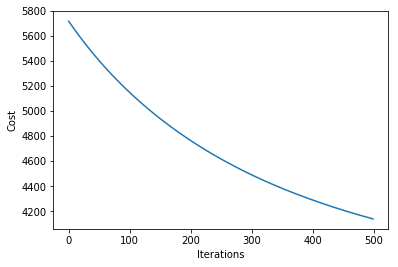

In [92]:
trained_model = model(trainSetXS, trainSetY, n_h = 533, n_ite = 500, lr=0.0001, lambd = 0.7, print_cost = True) 


In [93]:
# Prediction
def predictions(X):
      
    parameters = trained_model["parameters"]
    
    w1 = parameters["w1"]
    b1 = parameters["b1"]
    w2 = parameters["w2"]
    b2 = parameters["b2"]
    
    predictions = softmax(np.dot(w2.T, np.tanh(np.dot(w1.T, X) + b1)) + b2)
    
    for j in range(predictions.shape[1]):   
        for i in range(predictions.shape[0]):
            if predictions[i, j] <= 0.5:
                predictions[i, j] = 0
            else:
                predictions[i, j] = 1
    
    return predictions

In [94]:
# Accuracy
# y_predict_train -- the prediction of train set
# y_predict_test -- the prediction of test set


y_predict_train = predictions(trainSetXS)
y_predict_test = predictions(testSetXS)

print('the train accuracy is ', np.mean(y_predict_train == trainSetY.T)) # average similarity between two sets
#print(y_predict_test)
print('the test accuracy is ', np.mean(y_predict_test == testSetY.T))


the train accuracy is  0.8345
the test accuracy is  0.83197
